In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns= ['Sales']

<AxesSubplot:xlabel='DATE'>

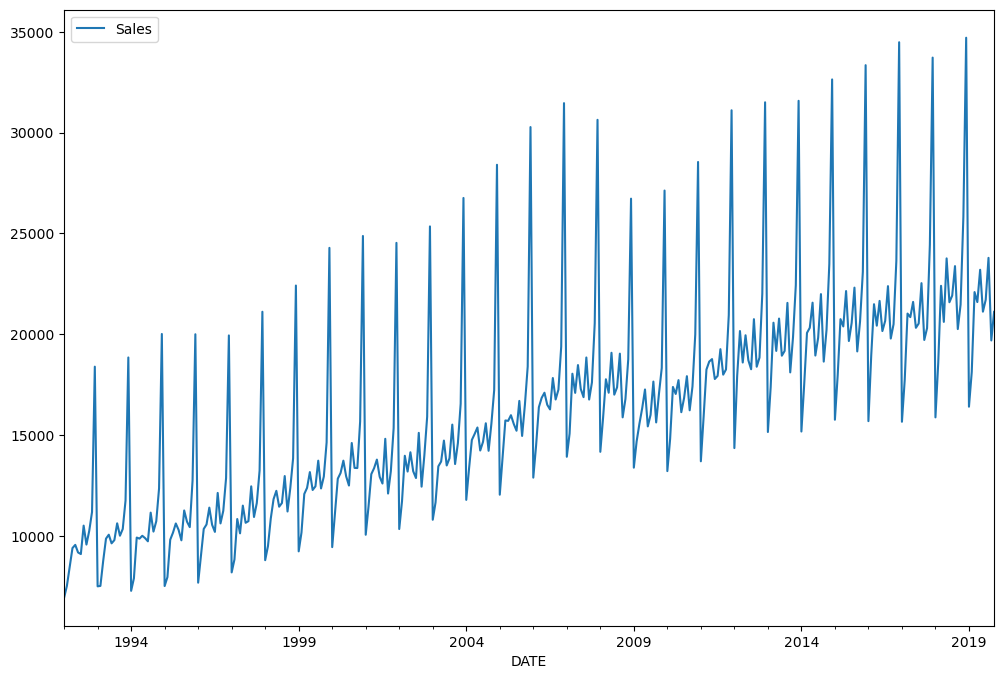

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [9]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [10]:
len(df)-18

316

In [12]:
test_size= 18
test_ind= len(df) - test_size

In [13]:
train = df.iloc[:test_ind]
test= df.iloc[test_ind:]

In [14]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [15]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler()

In [19]:
scaled_train = scaler.fit_transform(train)

In [20]:
scaled_test= scaler.fit_transform(test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
len(test)

18

In [23]:
length= 12

generator= TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [26]:
X,y= generator[0]

In [27]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [28]:
y

array([[0.02047633]])

In [30]:
from tensorflow.keras.models import Sequential

In [31]:
from tensorflow.keras.layers import Dense,LSTM

In [32]:
n_features=1

In [33]:
model= Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [37]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [38]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

C:\Users\User\AppData\Local\Temp\ipykernel_17768\3786894748.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])


Epoch 1/20
304/304 [==============================] - 4s 6ms/step - loss: 0.0243 - val_loss: 0.0062
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0166 - val_loss: 0.0185
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0102 - val_loss: 0.0143


In [39]:
losses= pd.DataFrame(model.history.history)

<AxesSubplot:>

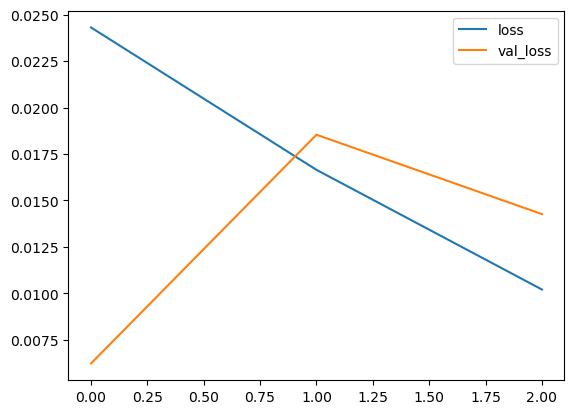

In [40]:
losses.plot()

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [42]:
#Inverse transform and Compare
true_predictions= scaler.inverse_transform(test_predictions)

In [43]:
test['Predictions']= true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_17768\715416204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']= true_predictions


In [44]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,27115.889195
2018-06-01,21589,26666.346876
2018-07-01,21919,26864.155311
2018-08-01,23381,27799.911088
2018-09-01,20260,26698.143359
2018-10-01,21473,27153.319339
2018-11-01,25831,31142.539728
2018-12-01,34706,35128.496170
2019-01-01,16410,25186.424333


<AxesSubplot:xlabel='DATE'>

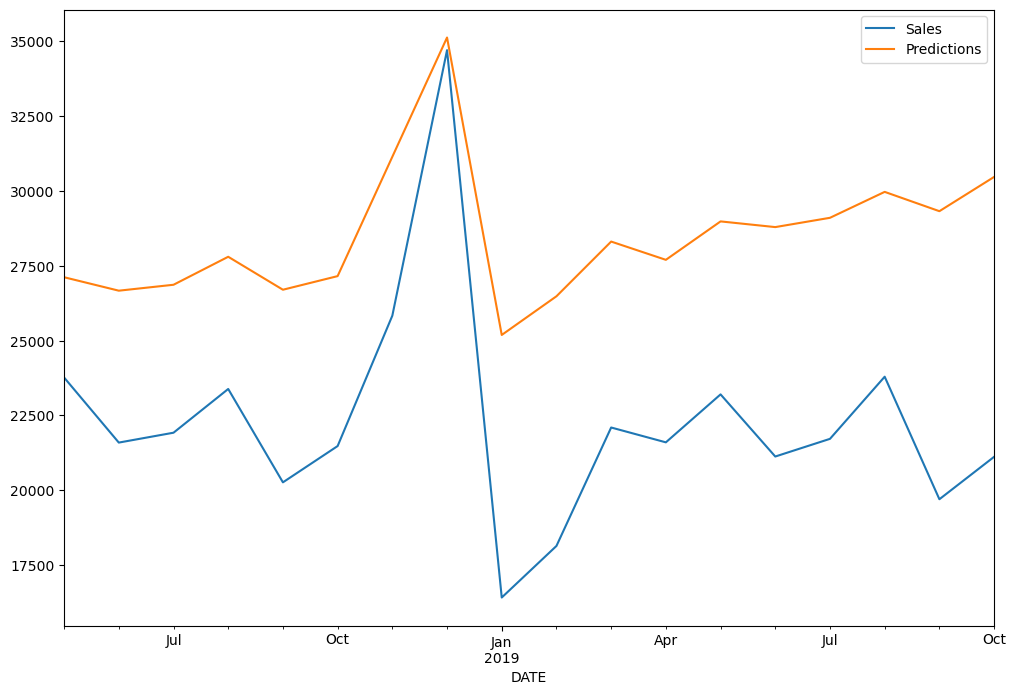

In [45]:
test.plot(figsize=(12,8))

In [46]:
#Scaling tthe entire data(DF)
full_scaler= MinMaxScaler()

In [47]:
scaled_full_data= full_scaler.fit_transform(df)

In [48]:
length= 12
generator=TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)

In [49]:
model= Sequential()

model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [50]:
model.fit_generator(generator,epochs=3)

Epoch 1/3


C:\Users\User\AppData\Local\Temp\ipykernel_17768\1054479155.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=3)


322/322 [==============================] - 3s 4ms/step - loss: 0.0237
Epoch 2/3
322/322 [==============================] - 1s 4ms/step - loss: 0.0177
Epoch 3/3
322/322 [==============================] - 1s 4ms/step - loss: 0.0096


In [51]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [52]:
forecast= scaler.inverse_transform(forecast)

In [55]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [56]:
forecast_index= pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [57]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [58]:
forecast_df= pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

(576.0, 611.0)

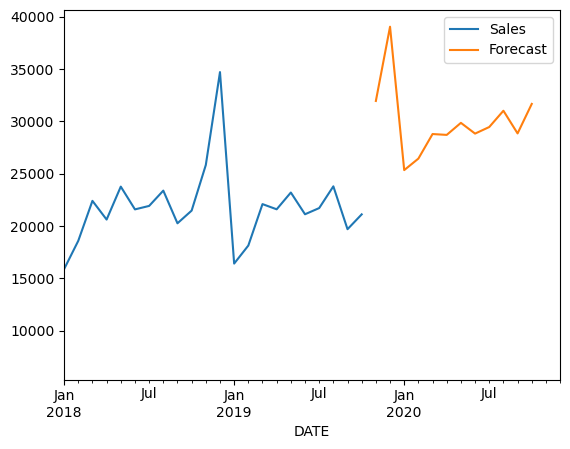

In [60]:
ax= df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')